# Bayesian Workflow in the 0-inflated model

##### Keywords: glm, regression, poisson regression, link-function, zero-inflated, mixture model, bayesian workflow

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import pymc3 as pm

//anaconda/envs/py3l/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Monks working on manuscripts

From McElreath:

>Now imagine that the monks take breaks on some days. On those days, no manuscripts are completed. Instead, the wine cellar is opened and more earthly delights are practiced. As the monastery owner, you'd like to know how often the monks drink. The obstacle for inference is that there will be zeros on honest non-drinking days, as well, just by chance. So how can you estimate the number of days spent drinking?

![](images/a-st-bernardus-prior-8.jpg)

The kind of model used to solve this problem is called a **Mixture Model**. We'll see these in more detail next week, but here is a simple version that arises in Poisson regression.

Let $p$ be the probability that the monks spend the day drinking, and $\lambda$ be the mean number of manuscripts completed, when they work.


### Likelihood

The likelihood of observing 0 manuscripts produced is is:

 $$\cal{L}(y=0) = p + (1-p) e^{-\lambda},$$

since the Poisson likelihood of $y$ is $ \lambda^y exp(–\lambda)/y!$

Likelihood of a non-zero $y$ is:

 $$\cal{L}(y \ne 0) = (1-p) \frac{\lambda^y e^{-\lambda}}{y!}$$

This model can be described by this diagram, taken from Mc-Elreath

![](images/zinfmonks.png)


### Generating the data

We're throwing bernoullis for whether a given day in the year is a drinking day or not...

In [2]:
from scipy.stats import binom
p_drink=0.2
rate_work=1
N=365
drink=binom.rvs(n=1, p=p_drink, size=N)
drink

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,

On days we dont drink, we produce some work...though it might be 0 work...

In [3]:
from scipy.stats import poisson
y = ( 1 - drink)*poisson.rvs(mu=rate_work, size=N)
y

array([0, 2, 1, 1, 0, 2, 1, 0, 2, 1, 1, 0, 0, 2, 1, 0, 0, 1, 0, 3, 1, 1,
       0, 0, 0, 3, 0, 0, 0, 1, 0, 2, 0, 0, 0, 3, 0, 0, 1, 1, 0, 3, 2, 0,
       0, 2, 1, 0, 2, 0, 0, 0, 0, 1, 1, 2, 0, 0, 0, 0, 0, 0, 2, 3, 0, 1,
       0, 0, 0, 0, 0, 0, 2, 1, 0, 1, 0, 2, 1, 0, 1, 2, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 2, 1, 1, 1, 0, 2, 3, 2, 0, 1, 1, 0, 2, 0, 0, 1, 0, 0, 1,
       0, 1, 2, 1, 0, 2, 1, 1, 0, 0, 0, 2, 0, 2, 1, 1, 0, 1, 0, 2, 1, 0,
       1, 2, 0, 3, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 1,
       3, 0, 0, 1, 0, 3, 1, 0, 1, 0, 0, 1, 1, 2, 1, 1, 4, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 2, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 3, 0, 0, 1, 0, 0, 0, 2, 0, 0, 1, 0, 3, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 2, 1, 1, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 3, 2, 2, 0, 0,
       2, 0, 1, 1, 0, 0, 2, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 3, 0, 0, 0, 0,
       1, 1, 3, 1, 0, 2, 3, 1, 0, 0, 1, 1, 2, 0, 1,

Lets manufacture a histogram of manuscripts produced in a day.

In [4]:
zeros_drink=np.sum(drink)
a=drink==0
b=y==0
zeros_work=np.sum(a & b)
zeros_drink, zeros_work, np.sum(b)

(82, 107, 189)

(array([189.,  98.,  55.,  21.,   2.,   0.,   0.,   0.,   0.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 9 Patch objects>)

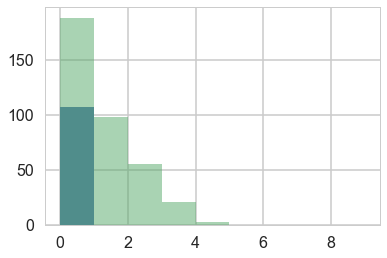

In [5]:
plt.hist(zeros_work*[0], bins=np.arange(10))
plt.hist(y, bins=np.arange(10), alpha=0.5)

### Lets throw in some domain expertise

*A survey of Abbey Heads has told us, that the most a monk could produce, ever, was 10 manuscripts in a day.*

## First model: just do a simple poisson

In [6]:
import theano.tensor as t

In [7]:
def model_poisson(observed=False):
    with pm.Model() as model:
        lam=pm.HalfNormal("lambda", 100)
        like = pm.Poisson("obsv", mu=lam, observed=observed)
    return model

In [8]:
model0 = model_poisson(observed=y)

In [10]:
with model0:
    trace0=pm.sample(3000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2301.56draws/s]


//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x125d3d9e8>,
      dtype=object)

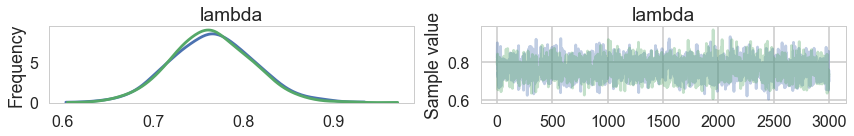

In [11]:
pm.traceplot(trace0)

In [12]:
pm.summary(trace0)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
lambda,0.765773,0.045322,0.000949,0.673305,0.850332,2366.278381,1.000073


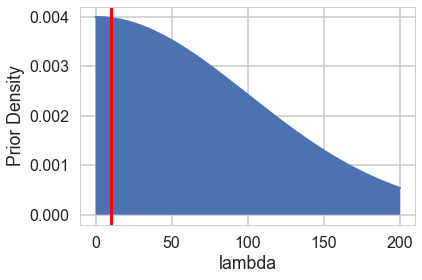

In [13]:
from scipy import stats
lbda  = np.linspace(0, 200, num=1000)
normpdf = stats.norm(loc=0,scale=100).pdf(lbda)
plt.plot(lbda, normpdf, lw=2)
plt.xlabel("lambda"); 
plt.ylabel("Prior Density");
plt.fill_between(lbda,0.,normpdf)
plt.axvline(10, 0 ,1, c="r", lw=3);

### Some proper workflow

Notice the prior specification though: at the 3$\sigma$ level, $\lambda$ could range from 0 to 300, ie from 0 to an extremely large number to an extremely large "mean" of counts. Not possible. Indeed, the max count is around 10. For a poisson, since the variance is equal to the mean, this means that (at 3$\sigma):

$$max(\lambda + 3\sqrt{\lambda}) < 10$$

Any prior should only take us marginally outside this range:

In [14]:
4+3*np.sqrt(4)

10.0

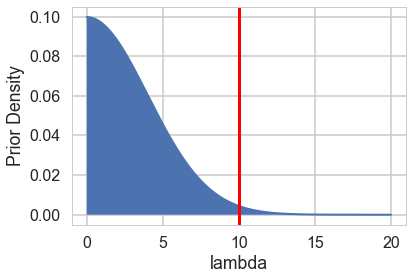

In [15]:
from scipy import stats
lbda  = np.linspace(0, 20, num=1000)
normpdf = stats.norm(loc=0,scale=4).pdf(lbda)
plt.plot(lbda, normpdf, lw=2)
plt.xlabel("lambda"); 
plt.ylabel("Prior Density");
plt.fill_between(lbda,0.,normpdf)
plt.axvline(10, 0 ,1, c="r", lw=3);

(array([331., 278., 104., 138.,  39.,  59.,  26.,  10.,  11.,   4.]),
 array([ 0. ,  1.6,  3.2,  4.8,  6.4,  8. ,  9.6, 11.2, 12.8, 14.4, 16. ]),
 <a list of 10 Patch objects>)

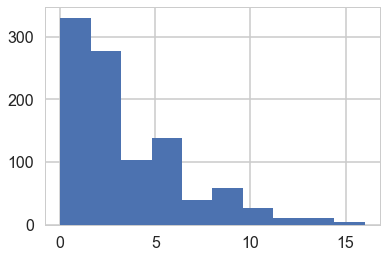

In [16]:
pois = stats.poisson.rvs(stats.halfnorm(scale=4).rvs(1000))
plt.hist(pois)

In [17]:
np.mean(pois > 10)

0.036

### Limiting the prior

Thus a prior should mainly limit $\lambda$ to values upto 4. To so this consider:

In [18]:
from scipy.stats import halfnorm
halfnorm.ppf(0.99, loc=0,scale=4)

10.303317214195602

In [19]:
def model_poisson1(sd, datasize, observed=False):
    with pm.Model() as model:
        lam=pm.HalfNormal("lambda", sd)
        like = pm.Poisson("obsv", mu=lam, shape = datasize, observed=observed)
    return model

### Simulating the Bayesian Joint distribution

This should be way enough!, So lets go again:


In [20]:
N = y.shape[0]
N

365

In [23]:
simu_lbdas = stats.halfnorm(scale=4).rvs(500)
simy = np.zeros((500, y.shape[0]))
for i in range(500):
    simy[i,:] = stats.poisson(simu_lbdas[i]).rvs(y.shape[0])

In [24]:
x_max = 21
bins = np.arange(0,x_max)
hists = np.apply_along_axis(lambda a: np.histogram(a, bins=bins)[0], 1, simy)

In [25]:
hists.shape #500 rows with 20 cols

(500, 20)

In [26]:
np.linspace(10,90,num=9, dtype=int)

array([10, 20, 30, 40, 50, 60, 70, 80, 90])

In [27]:
prctiles = np.percentile(hists,np.linspace(10,90,num=9, dtype=int),axis=0)

In [28]:
bin_interp = np.linspace(0,x_max-1,num=(x_max-1)*10)
bin_interp

array([ 0.        ,  0.10050251,  0.20100503,  0.30150754,  0.40201005,
        0.50251256,  0.60301508,  0.70351759,  0.8040201 ,  0.90452261,
        1.00502513,  1.10552764,  1.20603015,  1.30653266,  1.40703518,
        1.50753769,  1.6080402 ,  1.70854271,  1.80904523,  1.90954774,
        2.01005025,  2.11055276,  2.21105528,  2.31155779,  2.4120603 ,
        2.51256281,  2.61306533,  2.71356784,  2.81407035,  2.91457286,
        3.01507538,  3.11557789,  3.2160804 ,  3.31658291,  3.41708543,
        3.51758794,  3.61809045,  3.71859296,  3.81909548,  3.91959799,
        4.0201005 ,  4.12060302,  4.22110553,  4.32160804,  4.42211055,
        4.52261307,  4.62311558,  4.72361809,  4.8241206 ,  4.92462312,
        5.02512563,  5.12562814,  5.22613065,  5.32663317,  5.42713568,
        5.52763819,  5.6281407 ,  5.72864322,  5.82914573,  5.92964824,
        6.03015075,  6.13065327,  6.23115578,  6.33165829,  6.4321608 ,
        6.53266332,  6.63316583,  6.73366834,  6.83417085,  6.93

In [29]:
prctiles_interp = np.repeat(prctiles, 10,axis=1)

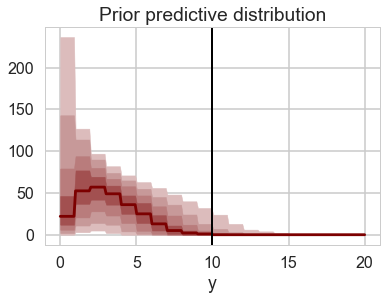

In [30]:
c_light ="#DCBCBC"
c_light_highlight ="#C79999"
c_mid ="#B97C7C"
c_mid_highlight ="#A25050"
c_dark ="#8F2727"
c_dark_highlight ="#7C0000"
for i,color in enumerate([c_light,c_light_highlight,c_mid,c_mid_highlight]):
    plt.fill_between(bin_interp,prctiles_interp[i,:],prctiles_interp[-1-i,:],alpha=1.0,color=color);


plt.plot(bin_interp,prctiles_interp[4,:],color=c_dark_highlight);
plt.axvline(x=10,ls='-',lw=2,color='k');
plt.xlabel('y');
plt.title('Prior predictive distribution');

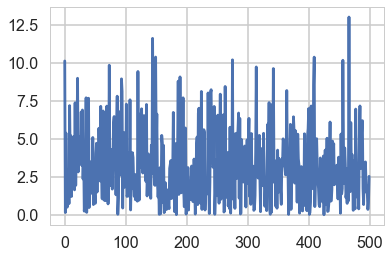

In [31]:
plt.plot(simu_lbdas);

In [41]:
R=200 #number of replications we choose for simulation based callibration
choices = np.random.choice(simu_lbdas.shape[0], R)
choices

array([101, 246, 476, 231, 170, 234,  14,  22, 116, 137, 222, 488, 396,
       179, 478, 357, 166, 225, 303,  18, 113, 148, 398, 243, 373, 256,
       145, 173, 381,  80, 272, 364,  67, 400, 293, 219, 308,  81,  51,
        81, 162, 434, 204, 324, 327, 394, 444, 440, 317, 142, 125, 337,
       400, 315, 186, 208,  58, 344, 321,  92, 362, 490, 274, 318, 162,
       243,  19,  51,  60,  76, 495,  30, 179, 317, 109, 489, 132, 408,
       427, 245,  91, 314,  69, 384,  15, 181, 360, 335, 386, 228,   9,
       177, 383, 445,   7, 109,  10, 153,  91,  72, 422,  87,  33,  70,
       336, 421, 496, 297,  62, 439, 432, 154, 117, 397,  97, 148, 142,
        83, 337, 490,  28,  41,  26,  25, 488, 103, 406, 404, 379, 311,
       135, 332,  38, 285, 147, 173, 292,  10, 247, 205, 178, 360, 222,
       232,  25, 311,  73, 481, 308, 375, 464,  18, 218,  60, 478, 336,
       479, 351, 323, 444, 147, 251,  82, 312, 217, 152, 260, 321, 346,
       384, 133,  82, 196, 334, 178, 292, 234, 137, 374, 128, 16

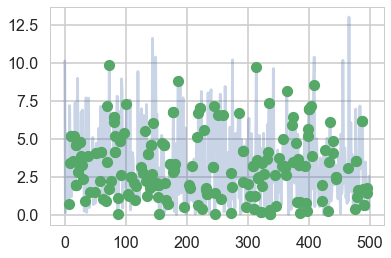

In [42]:
plt.plot(simu_lbdas, alpha=0.3)
plt.plot(choices, simu_lbdas[choices], 'o')

In [43]:
simlamsmall = simu_lbdas[choices]
simysmall = simy[choices,:]
simysmall.shape

(200, 365)

In [44]:
junkm = model_poisson1(4, y.shape[0], observed=simy[53,:])
with junkm:
    junkt = pm.sample(3000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2296.78draws/s]


In [45]:
simu_lbdas[53]

1.4991225903545407

//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1253cfda0>,
      dtype=object)

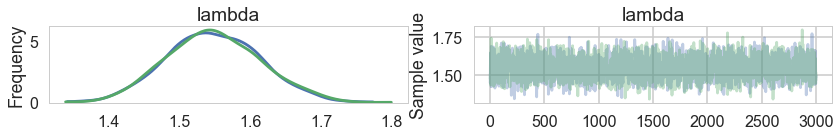

In [46]:
pm.traceplot(junkt)

In [47]:
pm.summary(junkt)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
lambda,1.548423,0.0658,0.001263,1.424511,1.68153,2442.392751,0.999848


In [48]:
junkt.report.ok

True

In [50]:
sbcpost = np.zeros((R, 6000))
problems = [False]*R
summaries = []
for i in range(R):
    m = model_poisson1(4, y.shape[0], observed=simysmall[i,:])
    junkt = pm.sample(3000, tune=1000, model=m, progressbar=False)
    sbcpost[i,:] = junkt['lambda']
    s = pm.stats.summary(junkt,varnames=['lambda'])
    summaries.append(s)
    problems[i] = junkt.report.ok

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]
The acceptance probability does not match the target. It is 0.8808644421197311, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]
Auto-assigning NUTS sampler...
Initializing 

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]
The acceptance probability does not match the target. It is 0.8863016117603773, but should be close to 0.8. Try to increase the number of 

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]
The acceptance probability does not match the target. It is 0.8843428382706925, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
N

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]
Auto

In [56]:
notp = ~np.array(problems)
notp

array([False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
        True, False,

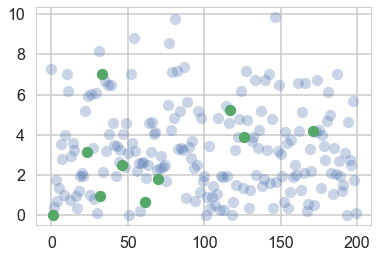

In [57]:
plt.plot(simlamsmall, 'o', alpha=0.3)
plt.plot(np.array(range(R))[notp], simlamsmall[notp], 'o')

### Calculating simulated posterior statistics

In [58]:
def sbc_rank(source_param, param_post, thin):
    return np.sum(source_param < param_post[::thin])
def z_scores_func(source_param, param_post):
    mean_param = np.mean(param_post)
    std_param = np.std(param_post)
    zs = np.abs(mean_param - source_param)/std_param
    return zs
def shrinkages_func(std_source, param_post):
    std_param = np.std(param_post)
    zs = 1. - (std_param*std_param)/(std_source*std_source)
    return zs    

In [59]:
summaries[0]

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
lambda,7.345933,0.141964,0.002917,7.076649,7.628386,2438.993346,0.999835


In [60]:
# posterior sensitivities analysis
z_scores = np.zeros(R)
shrinkages = np.zeros(R)
for i, s in enumerate(summaries):
    post_mean_lbda = s['mean'].values[0]
    #post_sd_lbda = s['sd'].values[0]
    prior_sd_lbda = 4.0
    print(simlamsmall[i], post_mean_lbda)
    #z_scores[i] = np.abs((post_mean_lbda - simlamsmall[i]) / post_sd_lbda)
    z_scores[i] = z_scores_func(simlamsmall[i], sbcpost[i,:])
    #shrinkages[i] = 1 - (post_sd_lbda / prior_sd_lbda ) ** 2
    shrinkages[i] = shrinkages_func(prior_sd_lbda, sbcpost[i,:])

7.2826984369820185 7.345932985903501
0.03619793200328896 0.03540082074039641
0.3954334191920077 0.4095846951880233
1.76460931533759 1.7947910375926843
0.6929353168768441 0.6754828559512187
1.3772673567042537 1.4735562245690907
3.5622233582365705 3.607859951653604
2.8231366999794942 2.8995741579839365
0.9876608574633664 1.0120167663109545
4.010897429351958 3.9387845425737273
7.018393121278332 7.225735422348905
6.197027986802879 6.209886534674978
0.7617387271263913 0.7515184933372625
2.933794186404721 2.873331297902717
3.573654980106229 3.68095804664517
3.2348128838315846 3.0821513810926664
0.9486328855665391 0.9882201822149745
0.35481926347662707 0.34303818936468555
1.220580091796372 1.118043846679517
1.9376093990928283 1.897105999338289
2.1027849714499447 2.1397263961363047
1.9391516398475588 1.97112499535163
5.20406416845636 5.187409085166008
3.1318077921978493 3.0516719226401157
5.902794100633386 5.7458538907281715
1.0230550306538866 0.9961245770215215
6.036407719308618 6.20415808750

### Shrinkage Plot

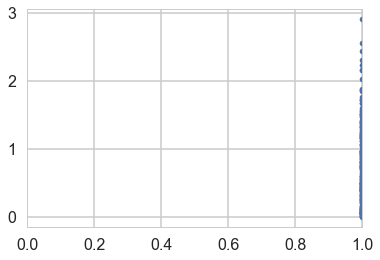

In [61]:
plt.plot(shrinkages, z_scores, '.');
plt.xlim([0,1]);

### Simulation Based Callibration

In [62]:
ranks=np.empty(R, dtype='int')
for i, lam in enumerate(simlamsmall):
    ranks[i] = sbc_rank(lam, sbcpost[i,:], 4)
ranks

array([ 999,  655,  965, 1007,  510, 1411, 1003, 1199,  986,  358, 1395,
        795,  618,  347, 1273,   82, 1157,  529,   52,  420, 1030,  957,
        661,  271,  158,  444, 1350,  967,  703,  945,  751,  708,  352,
       1235,  457,  824,   75, 1373,   27, 1393,  113, 1426,  661,  283,
       1033, 1187,  818, 1015, 1141,  249, 1133, 1458, 1249,  188, 1054,
       1078, 1375,  533,  523,  917, 1227,  801,  902, 1205,  165,  262,
        238,   25,  946,  759,  175,  227,  367, 1161, 1027,  960, 1312,
        742,  978, 1486,  306, 1121,  535,  786,  717,  338, 1029,   15,
        115,    5,  189, 1357,  204,  815,  158, 1023,  627,   96,  318,
        172,  979,  368,  512,  787,  660,  737, 1322,  223,  925,   89,
        166,  437, 1387,  861,  176, 1001,  251, 1028, 1453,  773, 1052,
        719, 1413,   46,  826,    3,  323, 1078,  123,  693,  469,  211,
       1192,  136, 1161,  938,  583,  609, 1427,  604,  171, 1075, 1384,
       1005,   54,  716,  886,  160,   78,  601,  7

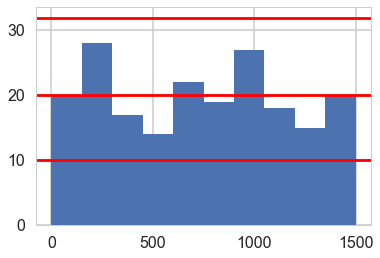

In [64]:
# 1500 left over samples after thinning, 1501 spots, R=200 replications
sbc_low = stats.binom.ppf(0.005, R, 150.0 / 1501)
sbc_mid = stats.binom.ppf(0.5, R, 150.0 / 1501)
sbc_high = stats.binom.ppf(0.995, R, 150.0 / 1501)
plt.hist(ranks, bins=[150*x for x in range(11)]);
plt.axhline(sbc_low, 0,1, c='r')
plt.axhline(sbc_mid, 0,1, c='r')
plt.axhline(sbc_high, 0,1, c='r')

### Posterior Predictive Check

In [65]:
mpo = model_poisson1(4, y.shape[0], observed=y)
with mpo:
    samples = pm.sample(3000, tune=1000)
posterior = samples.get_values('lambda')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2109.25draws/s]


//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


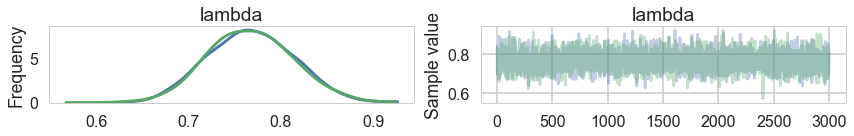

In [66]:
pm.traceplot(samples);

In [67]:
with mpo:
    samples_ppc = pm.sample_ppc(samples)

100%|██████████| 3000/3000 [00:01<00:00, 2275.59it/s]


In [68]:
samples_ppc['obsv'].shape

(3000, 365)

//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


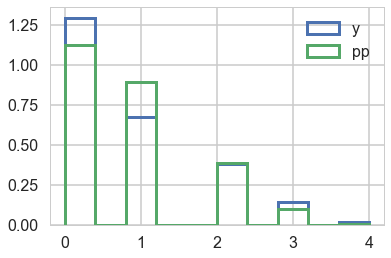

In [69]:
plt.hist(y,  normed=True, histtype='step', lw=3, label="y");
plt.hist(samples_ppc['obsv'][0,:],  normed=True, histtype='step', lw=3, label="pp")
plt.legend();

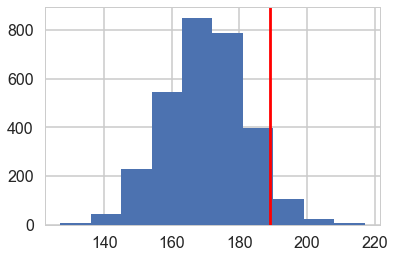

In [70]:
zeros = np.zeros(3000)
for i in range(3000):
    zeros[i] = np.sum(samples_ppc['obsv'][i,:]==0)
plt.hist(zeros)
plt.axvline(np.sum(y==0), 0,1, c='r')

## A second model: 0 inflated poisson

The likelihood that combines the two cases considered above is called the **Zero Inflated poisson**. It has two arguments, the Poisson rate parameter, and the proportion of poisson variates (theta and psi in pymc).

In [71]:
def model_0ipoisson1(sd, shp, observed=None):
    with pm.Model() as model:
        lam=pm.HalfNormal("lambda", sd)
        theta=pm.Beta("theta", 1,1)
        like = pm.ZeroInflatedPoisson("obsv", theta=lam, psi=theta, shape = shp, observed=observed)
    return model

In [72]:
model2 = model_0ipoisson1(4, y.shape[0], observed=y)
with model2:
    trace2 = pm.sample(3000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:06<00:00, 1193.56draws/s]


//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


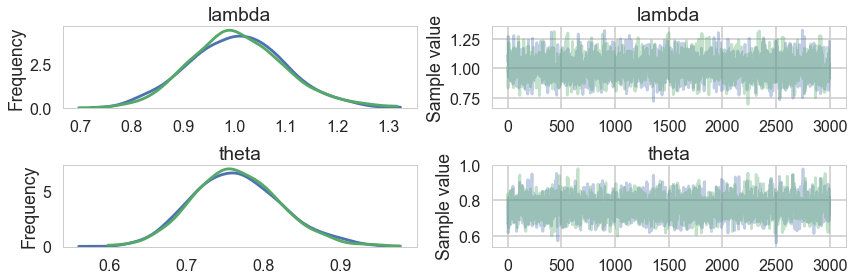

In [73]:
pm.traceplot(trace2);

In [74]:
pm.summary(trace2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
lambda,1.006511,0.092614,0.002081,0.824101,1.192509,1882.153174,0.999892
theta,0.765535,0.057240,0.001329,0.659945,0.882764,1812.193668,0.999836


### Identifiability Problems through simple prior-predictive checks

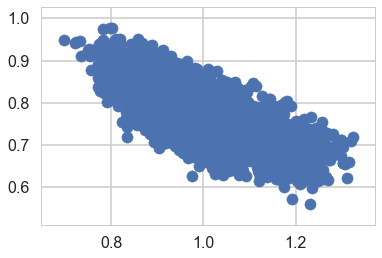

In [75]:
plt.scatter(trace2['lambda'], trace2['theta'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x129bc9588>,
      dtype=object)

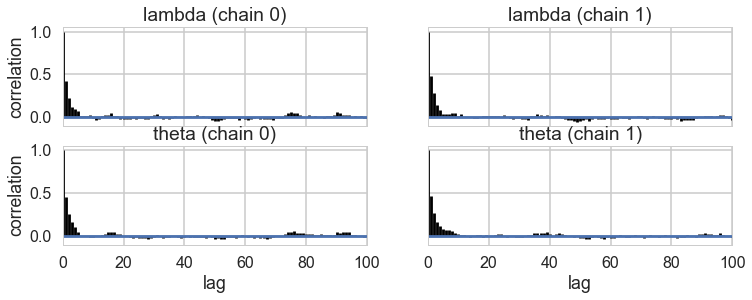

In [76]:
pm.autocorrplot(trace2)

### Sampling some prior predictives

We sample those likely to be troublesome, especially high drunkenness probability, and low productivity

In [77]:
simu_lbdas2 = stats.halfnorm(scale=4).rvs(500)
simu_betas2 = stats.beta(1,1).rvs(500)
simy2 = np.zeros((500, N))
for i in range(500):
    simu_bern = stats.bernoulli(1 - simu_betas2[i]).rvs(N).astype('bool')
    indices = np.array(range(N))[simu_bern]
    simy2[i,indices] = stats.poisson(simu_lbdas2[i]).rvs(indices.shape[0])

In [78]:
simy2[0,:].shape, simy2[53,:].shape

((365,), (365,))

In [79]:
lowlamindices = np.argsort(simu_lbdas2)[:5]
lowlamindices, simu_lbdas2[lowlamindices]

(array([ 25, 218,  94, 133, 397]),
 array([0.00236154, 0.00580884, 0.02587444, 0.02740405, 0.03943001]))

In [80]:
highpindices = np.argsort(simu_betas2)[-5:]
highpindices, simu_betas2[highpindices]

(array([118, 112, 243, 442, 113]),
 array([0.99627351, 0.99664489, 0.99836319, 0.99930241, 0.99959989]))

In [81]:
reps_to_sample = np.concatenate((lowlamindices, highpindices))
reps_to_sample

array([ 25, 218,  94, 133, 397, 118, 112, 243, 442, 113])

In [82]:
reps_to_sample2 = np.concatenate((np.argsort(simu_lbdas2)[181:186], np.argsort(simu_betas2)[181:186]))

In [83]:
for j in reps_to_sample:
    m = model_0ipoisson1(4, N, observed=simy2[j,:])
    t = pm.sample(3000, tune=1000, model=m)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:08<00:00, 890.89draws/s] 
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:10<00:00, 769.78draws/s]
The acceptance probability does not match the target. It is 0.8833682804304704, but should be close to 0.8. Try to increase the number of tuning steps.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS

And these are more reasonable models to compare...

In [84]:
for j in reps_to_sample2:
    m = model_0ipoisson1(4, N, observed=simy2[j,:])
    t = pm.sample(3000, tune=1000, model=m)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:06<00:00, 1321.62draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1460.35draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1456.51draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1431.31draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta,

## In search of a better model

### Lets throw in some domain expertise

*A survey of Abbey Heads has told us, that the most a monk would produce, even at low productivity, one manuscript a day.*

### Choosing better Priors

In [85]:
cdfig = lambda alpha, beta: stats.invgamma(alpha,scale=beta).cdf(1)

In [86]:
asp = np.linspace(2,5,100)
bsp = np.linspace(7,10,100)
aa,bb = np.meshgrid(asp, bsp)
aa

array([[2.        , 2.03030303, 2.06060606, ..., 4.93939394, 4.96969697,
        5.        ],
       [2.        , 2.03030303, 2.06060606, ..., 4.93939394, 4.96969697,
        5.        ],
       [2.        , 2.03030303, 2.06060606, ..., 4.93939394, 4.96969697,
        5.        ],
       ...,
       [2.        , 2.03030303, 2.06060606, ..., 4.93939394, 4.96969697,
        5.        ],
       [2.        , 2.03030303, 2.06060606, ..., 4.93939394, 4.96969697,
        5.        ],
       [2.        , 2.03030303, 2.06060606, ..., 4.93939394, 4.96969697,
        5.        ]])

In [87]:
z=cdfig(aa,bb)

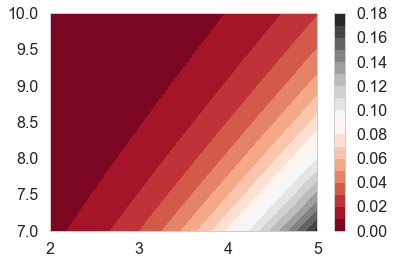

In [88]:
plt.contourf(aa, bb, z, 20, cmap='RdGy')
plt.colorbar();

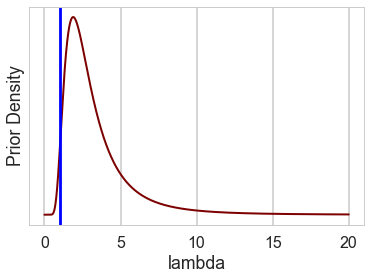

In [89]:
lbda  = np.linspace(0, 20, num=int(20/0.001))
alpha=3.5
beta=8.5
pdf = stats.invgamma(alpha, scale=beta)
plt.plot(lbda, pdf.pdf(lbda), c=c_dark_highlight, lw=2)
plt.xlabel("lambda"); plt.ylabel("Prior Density"); plt.yticks([]);
plt.axvline(1, 0, 1, c="blue")

In [90]:
stats.invgamma(alpha, scale=beta).cdf(1.), 1 - stats.invgamma(alpha, scale=beta).cdf(9.)

(0.017396182569124504, 0.0342667918309546)

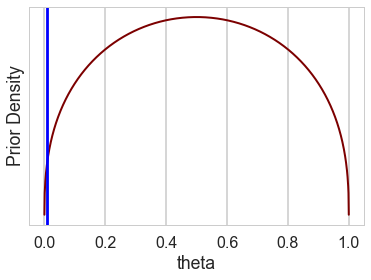

In [91]:
theta  = np.linspace(0, 1, num=int(1/0.001))
curve=1.4
pdf = stats.beta(curve, curve)
plt.plot(theta, pdf.pdf(theta), c=c_dark_highlight, lw=2)
plt.xlabel("theta"); plt.ylabel("Prior Density"); plt.yticks([]);
plt.axvline(0.01, 0, 1, c="blue")

In [92]:
stats.beta(curve, curve).cdf(0.2), 1 - stats.beta(curve, curve).cdf(0.8)

(0.15200913356356724, 0.15200913356356716)

In [93]:
def model_0ipoisson2(alpha, beta, curve, shp, observed=None):
    with pm.Model() as model:
        lam = pm.InverseGamma("lambda",alpha=alpha,beta=beta)
        theta=pm.Beta("theta", curve, curve)
        like = pm.ZeroInflatedPoisson("obsv", theta=lam, psi=theta, shape = shp, observed=observed)
    return model

### Quick Posterior Predictive

In the meanwhile, here is the posterior predictive

In [94]:
model3 = model_0ipoisson2(alpha, beta, curve, y.shape[0], observed=y)
with model3:
    trace3 = pm.sample(3000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:07<00:00, 1053.30draws/s]


In [95]:
pm.summary(trace3)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
lambda,1.041342,0.089236,0.001997,0.877989,1.227242,1989.053944,1.001134
theta,0.747666,0.054828,0.001371,0.646006,0.859916,1555.073911,1.001301


//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


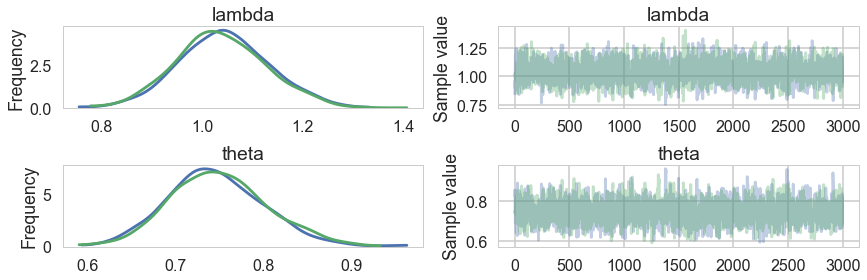

In [97]:
pm.traceplot(trace3);

### Sampling some prior predictives

Once again, we are looking at those likely to be troublesome...

In [108]:
simu_lbdas3 = stats.invgamma(alpha, scale=beta).rvs(500)
simu_betas3 = stats.beta(curve, curve).rvs(500)
simy3 = np.zeros((500, N))
for i in range(500):
    simu_bern = stats.bernoulli(1 - simu_betas3[i]).rvs(N).astype('bool')
    indices = np.array(range(N))[simu_bern]
    simy3[i,indices] = stats.poisson(simu_lbdas3[i]).rvs(indices.shape[0])

In [109]:
lowlamindices = np.argsort(simu_lbdas3)[:5]
lowlamindices, simu_lbdas3[lowlamindices]


(array([467, 484, 300, 338,  82]),
 array([0.74253068, 0.90654821, 0.93076548, 0.93337921, 1.00774676]))

In [110]:
for j in lowlamindices:
    m = model_0ipoisson2(alpha, beta, curve, N, observed=simy3[j,:])
    t = pm.sample(3000, tune=1000, model=m)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:06<00:00, 1229.79draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:07<00:00, 1084.03draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:07<00:00, 1095.60draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:08<00:00, 958.98draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta,

In [111]:
highpindices = np.argsort(simu_betas3)[-5:]
highpindices, simu_betas3[highpindices]

(array([178,  44, 409, 100, 306]),
 array([0.97579352, 0.9798864 , 0.98467105, 0.98573803, 0.99104879]))

In [112]:
for j in highpindices:
    m = model_0ipoisson2(alpha, beta, curve, N, observed=simy3[j,:])
    t = pm.sample(3000, tune=1000, model=m)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:06<00:00, 1238.25draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:07<00:00, 1037.76draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:07<00:00, 1122.96draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:07<00:00, 1068.12draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS us

In [114]:
for j in highpindices:
    m = model_0ipoisson2(alpha, beta, curve, N, observed=simy3[j,:])
    t = pm.sample(3000, tune=1000, model=m, nuts_kwargs=dict(target_accept=.90))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:08<00:00, 930.86draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:08<00:00, 952.02draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:07<00:00, 1059.14draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:07<00:00, 1103.28draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta,

### The complete prior-predictive run

We seem much better so we fit all the prior predictives (well 200 of them).

In [117]:
choices = np.random.choice(simu_lbdas2.shape[0], R)
simlamsmall3 = simu_lbdas3[choices]
simthetasmall3 = simu_betas3[choices]
simysmall3 = simy3[choices,:]
simysmall3.shape

(200, 365)

In [153]:
simthetasmall3 = 1. - simu_betas3[choices]

In [118]:
sbcpost3_lambda = np.zeros((R, 6000))
sbcpost3_theta = np.zeros((R, 6000))


problems3 = [False]*R
summaries3 = []
for i in range(R):
    m = model_0ipoisson2(alpha, beta, curve, N, observed=simysmall3[i,:])
    junkt = pm.sample(3000, tune=1000, model=m, progressbar=False, nuts_kwargs=dict(target_accept=.90))
    sbcpost3_lambda[i,:] = junkt['lambda']
    sbcpost3_theta[i,:] = junkt['theta']
    s3 = pm.stats.summary(junkt,varnames=['lambda', 'theta'])
    summaries3.append(s3)
    problems3[i] = junkt.report.ok

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Auto-assignin

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Auto-assigning NUTS sampler...
Initializing 

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess 

NUTS: [theta, lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta,

In [119]:
notp3 = ~np.array(problems3)
notp3

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

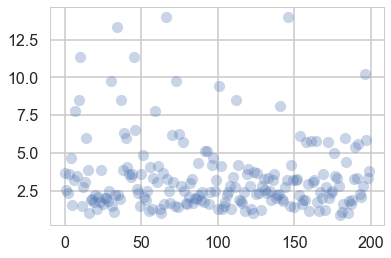

In [120]:
plt.plot(simlamsmall3, 'o', alpha=0.3)
plt.plot(np.array(range(R))[notp3], simlamsmall3[notp3], 'o')

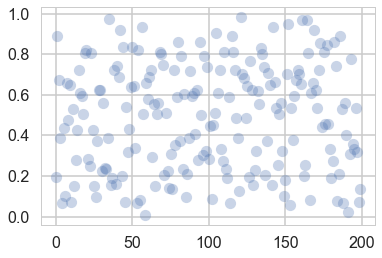

In [154]:
plt.plot(simthetasmall3, 'o', alpha=0.3)
plt.plot(np.array(range(R))[notp3], simthetasmall3[notp3], 'o')

### Calculate SBC metrics

In [155]:
prior_sd_lbda3 = np.std(stats.invgamma(alpha, scale=beta).rvs(10000))
prior_sd_theta3 = np.std(stats.beta(curve, curve).rvs(10000))
print(prior_sd_lbda3, prior_sd_theta3)
z_scores_lambda = np.zeros(R)
shrinkages_lambda = np.zeros(R)
z_scores_theta = np.zeros(R)
shrinkages_theta = np.zeros(R)
for i, s in enumerate(summaries3):
    z_scores_lambda[i] = z_scores_func(simlamsmall3[i], sbcpost3_lambda[i,:])
    shrinkages_lambda[i] = shrinkages_func(prior_sd_lbda3, sbcpost3_lambda[i,:])
    z_scores_theta[i] = z_scores_func(simthetasmall3[i], sbcpost3_theta[i,:])
    shrinkages_theta[i] = shrinkages_func(prior_sd_theta3, sbcpost3_theta[i,:])

2.773823066212632 0.2557066940108662


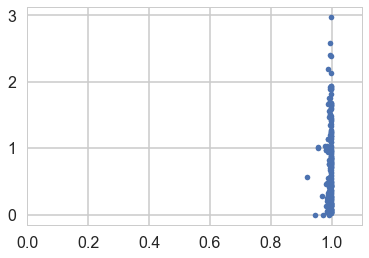

In [163]:
plt.plot(shrinkages_lambda, z_scores_lambda, '.');
plt.xlim([0,1.1]);

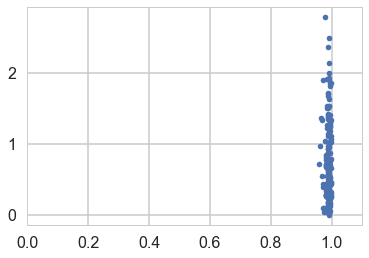

In [164]:
plt.plot(shrinkages_theta, z_scores_theta, '.');
plt.xlim([0,1.1]);

In [165]:
ranks3_lambda=np.empty(R, dtype='int')
for i, lam in enumerate(simlamsmall3):
    ranks3_lambda[i] = sbc_rank(lam, sbcpost3_lambda[i,:], 4)
ranks3_lambda

array([ 738, 1146, 1195,   53,  920, 1394,  314,   37, 1326,  665, 1286,
        578, 1196,  362,  681, 1026, 1432,  844,  325,  688,  830, 1437,
        963,  632,  578,  668,  921, 1178, 1234, 1413,  858, 1133,  959,
        110, 1044, 1360, 1448,  675, 1063,   22,  186,  818, 1213, 1401,
       1403, 1256, 1258,  928, 1319, 1218, 1407, 1431,  495, 1276, 1498,
       1325, 1324,  563,  418,   41,  191,  534, 1183,  326,  466,  672,
       1420,  765,  384,  850, 1027,  185,  505,  874, 1402,  519, 1233,
        690, 1412,  637,  587, 1191, 1254,   67, 1352,  928,  856,  227,
       1378,  856,   42,  246,  147,  905,  594,   79,  855,  281, 1055,
       1330, 1428,  109,  449,  725,  468, 1375,  493, 1206,  251,  326,
        307, 1412,  738,  220, 1274, 1169, 1146, 1204,  800,   46,  605,
        535, 1047, 1083, 1272, 1466,  755,   26,  552,  959,  773,  675,
       1049,  786, 1455,  612, 1345, 1041, 1178, 1493, 1165,  628,  777,
        834,  782,  981, 1435, 1168, 1368,  328, 10

In [166]:
ranks3_theta=np.empty(R, dtype='int')
for i, theta in enumerate(simthetasmall3):
    ranks3_theta[i] = sbc_rank(theta, sbcpost3_theta[i,:], 4)
ranks3_theta

array([ 488, 1056,  991, 1221,  457,  421, 1380, 1451, 1089,   80, 1459,
       1282, 1139,  626, 1353,  639,   52, 1217,  323,  899,  249, 1376,
        317,  914, 1364, 1141,  441,  117,  592,  606,  834,  588, 1117,
        361, 1079,   28,  828, 1004,  618, 1480,  972,  684,  693,  576,
       1342, 1475, 1136, 1311, 1133,  312, 1323,  737,  371,  567,   72,
        556, 1274,  502, 1300, 1446, 1488,  930,  683, 1055, 1126, 1136,
        541,   64, 1037, 1171,  759, 1083,  650,  848,  320,  126,  146,
        897,  923,  355,  376,  425,  357,  461,  585,  495,  176,  392,
       1099, 1199,  498, 1192,   98,  287,  362,  685, 1411,  917,  258,
        259, 1330, 1218,  856,  734,  692,  163,  387,  551,  754,  921,
       1306,  366, 1008, 1156,  518,  108,  714,  537,  775, 1267, 1014,
        172,  508,  352,  332,  859,  462,  650, 1360, 1194, 1049,  626,
       1249, 1307,  386,  889,  228,  141,  126,  446,  546,  765,  649,
       1448,  358,  366,  597,  568,  143, 1362,  4

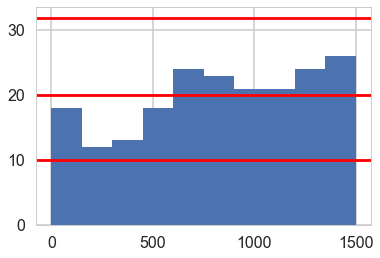

In [167]:
plt.hist(ranks3_lambda, bins=[150*x for x in range(11)]);
plt.axhline(sbc_low, 0,1, c='r')
plt.axhline(sbc_mid, 0,1, c='r')
plt.axhline(sbc_high, 0,1, c='r')

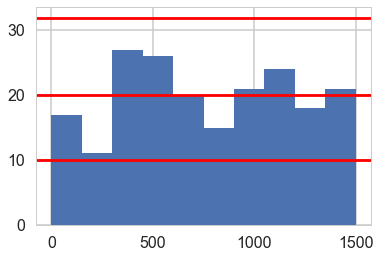

In [168]:
plt.hist(ranks3_theta, bins=[150*x for x in range(11)]);
plt.axhline(sbc_low, 0,1, c='r')
plt.axhline(sbc_mid, 0,1, c='r')
plt.axhline(sbc_high, 0,1, c='r')

### Get the actual data posteriors

In [138]:
with model3:
    trace3 = pm.sample(3000, tune=1000, nuts_kwargs=dict(target_accept=.90))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lambda]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:07<00:00, 1060.39draws/s]


//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13735f198>,
      dtype=object)

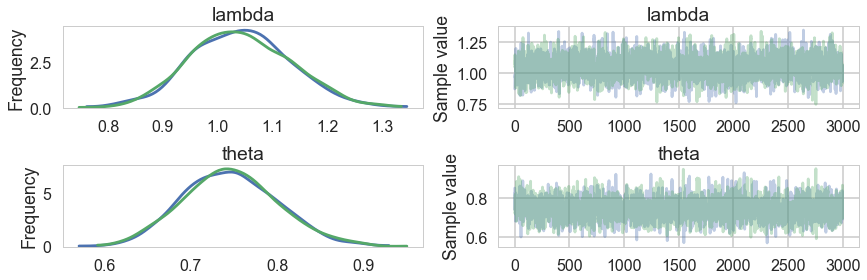

In [169]:
pm.traceplot(trace3)

In [170]:
pm.summary(trace3)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
lambda,1.043065,0.091843,0.002315,0.857643,1.216118,1797.100937,0.999836
theta,0.746728,0.054643,0.001399,0.644226,0.855818,1730.335495,0.999898


In [139]:
with model3:
    trace3_ppc = pm.sample_ppc(trace3)

100%|██████████| 3000/3000 [00:02<00:00, 1328.61it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x134211240>,
      dtype=object)

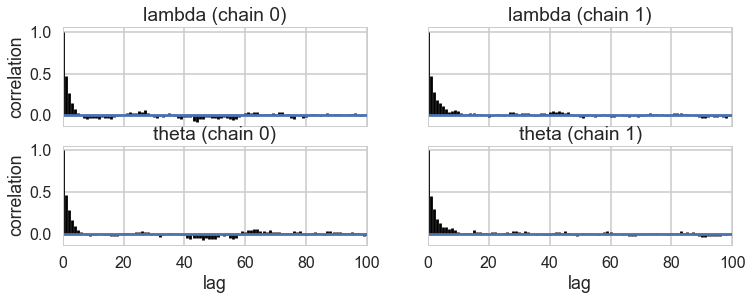

In [148]:
pm.autocorrplot(trace3)

### Posterior Predictive Checks

//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


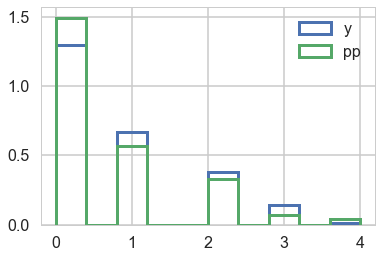

In [140]:
plt.hist(y,  normed=True, histtype='step', lw=3, label="y");
plt.hist(trace3_ppc['obsv'][0,:],  normed=True, histtype='step', lw=3, label="pp")
plt.legend();

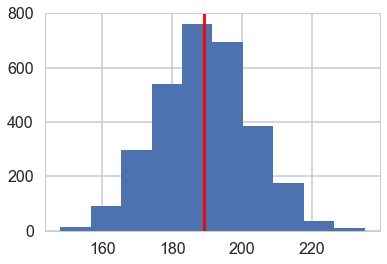

In [141]:
zeros3 = np.zeros(3000)
for i in range(3000):
    zeros3[i] = np.sum(trace3_ppc['obsv'][i,:]==0)
plt.hist(zeros3)
plt.axvline(np.sum(y==0), 0,1, c='r')